# GD2T2D: Model Building

In this notebook we will:
- Create the validation framework
- Test models
- Fine tune the models
- Find the best model

In [1]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = "../data/processed/decoded_data.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

## Creating the validation framework

In [5]:
from sklearn.model_selection import train_test_split

In [6]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [7]:
df_full_train.reset_index(drop=True)

,older_maternal_age,high_pre_pregnancy_bmi_or_overweight,family_history_of_diabetes,socioeconomic_factors_deprivation_quintile,presence_of_t2dm_associated_gene_variants,ethnicity,multiparity,insulin_treatment_during_pregnancy,pregnancy_complications_hypertensive_disorders,pregnancy_complications_preterm_delivery,...,perinatal_outcome_28_day_mortality,obesity_or_unhealthy_postpartum_weight_gain,physical_inactivity,unhealthy_diet,smoking,alcohol_intake,does_not_undergo_postpartum_glucose_screening,breastfeeding,history_of_recurrence_of_gdm,t2dm_risk
0,no,yes,no,1,no,asian,yes,yes,yes,yes,...,no,yes,yes,no,no,no,yes,no,no,1
1,yes,yes,no,3,no,asian,no,yes,yes,no,...,no,yes,yes,no,no,yes,yes,no,no,0
2,no,yes,no,5,no,white,no,yes,yes,no,...,no,no,yes,no,yes,yes,no,no,no,1
3,no,yes,no,3,no,black,no,no,no,no,...,no,yes,yes,no,no,yes,no,yes,no,0
4,no,no,no,3,no,white,no,no,no,no,...,no,no,no,no,no,yes,no,no,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,yes,no,no,3,no,other,no,no,no,no,...,no,yes,yes,yes,no,no,yes,yes,no,0
4796,no,no,no,2,no,asian,yes,no,no,no,...,no,yes,no,no,no,yes,no,yes,no,0
4797,yes,yes,no,4,no,mixed,yes,yes,yes,yes,...,no,yes,yes,yes,no,no,no,yes,yes,1
4798,no,yes,yes,2,no,white,yes,no,yes,yes,...,no,yes,yes,yes,no,yes,no,no,no,1


In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train.t2dm_risk.values
y_val = df_val.t2dm_risk.values
y_test = df_test.t2dm_risk.values

In [10]:
del df_train['t2dm_risk']
del df_val['t2dm_risk']
del df_test['t2dm_risk']

## Initial Model Training

In this section we will train the following models on the `df_train` data and validate using the validation data. The following models will be tested:
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier



In [11]:
## imports model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


from sklearn.feature_extraction import DictVectorizer

## Metrics imports
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score



### Decision Tree Classifier

In [12]:
# Create dictionaries for the feature matrix
train_dicts = df_train.to_dict(orient='records')

# Then vectorise those dictionaries
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

#Instantiate the decisiontree classifier and train it
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


y_pred = dt.predict_proba(X_val)[:, 1]

scores = []
model = "decision_tree"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))


In [13]:
columns = ['model', 'auc', 'f1', 'acc', 'prec', 'rec']
df_scores = pd.DataFrame(scores, columns=columns)

In [14]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.782852,0.667758,0.830833,0.653846,0.682274


### Random Forest Classifer

In [15]:
# Create dictionaries for the feature matrix
train_dicts = df_train.to_dict(orient='records')

# Then vectorise those dictionaries
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

#Instantiate the decisiontree classifier and train it
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)


y_pred = rf.predict_proba(X_val)[:, 1]

scores = []
model = "random_forest"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))
df_scores.loc[len(df_scores)] = scores[0]



In [16]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.782852,0.667758,0.830833,0.653846,0.682274
1,random_forest,0.907674,0.729904,0.860000,0.702786,0.759197


### XGBoost 

In [17]:
features = list(dv.get_feature_names_out())

features

['abnormal_ogtt_results=abnormal',
 'abnormal_ogtt_results=normal',
 'alcohol_intake=no',
 'alcohol_intake=yes',
 'breastfeeding=no',
 'breastfeeding=yes',
 'does_not_undergo_postpartum_glucose_screening=no',
 'does_not_undergo_postpartum_glucose_screening=yes',
 'elevated_hba1c_during_pregnancy=elevated',
 'elevated_hba1c_during_pregnancy=normal',
 'ethnicity=asian',
 'ethnicity=black',
 'ethnicity=mixed',
 'ethnicity=other',
 'ethnicity=white',
 'family_history_of_diabetes=no',
 'family_history_of_diabetes=yes',
 'gestational_weight_gain=no',
 'gestational_weight_gain=yes',
 'high_pre_pregnancy_bmi_or_overweight=no',
 'high_pre_pregnancy_bmi_or_overweight=yes',
 'history_of_recurrence_of_gdm=no',
 'history_of_recurrence_of_gdm=yes',
 'instrumental_delivery=no',
 'instrumental_delivery=yes',
 'insulin_treatment_during_pregnancy=no',
 'insulin_treatment_during_pregnancy=yes',
 'large_for_gestational_age=no',
 'large_for_gestational_age=yes',
 'macrosomia_baby_birth_weightdelivered_a_ba

In [18]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [19]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

y_pred = model.predict(dval)

scores = []
model = "XGBoost"
auc = roc_auc_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred >= 0.5)
acc = accuracy_score(y_val, y_pred >= 0.5)
prec = precision_score(y_val, y_pred >= 0.5)
rec = recall_score(y_val, y_pred >= 0.5)
scores.append((model, auc, f1, acc, prec, rec))
df_scores.loc[len(df_scores)] = scores[0]



In [20]:
df_scores

,model,auc,f1,acc,prec,rec
0,decision_tree,0.782852,0.667758,0.830833,0.653846,0.682274
1,random_forest,0.907674,0.729904,0.860000,0.702786,0.759197
2,XGBoost,0.923598,0.731293,0.868333,0.743945,0.719064


Without any model tuning, decision tree performance is not close to the other two models in ROC AUC score. Out of the box, both random forest and XGboost perform well. Next steps will be to tune the models to see the impact this has on performance.

## Model Parameter Tuning

### Decision Tree Parameter Tuning

In this subsection we will finetune the following decision tree paramters:
- max_depth
- min_samples
- 

Performance will be measure with AUC 

In [25]:
dt_scores = []

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples = [1, 5, 10, 15, 20, 500, 100, 200]

for depth in depths:
    for ms in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=ms)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred >= 0.5)
        acc = accuracy_score(y_val, y_pred >= 0.5)
        prec = precision_score(y_val, y_pred >= 0.5)
        rec = recall_score(y_val, y_pred >= 0.5)

        dt_scores.append((depth, ms, auc, f1, acc, prec, rec))

columns = ['max_depth', 'min_samples_leaf', 'auc', 'f1', 'acc', 'prec', 'rec']
df_dt_ft_scores = pd.DataFrame(dt_scores, columns=columns)

In [26]:
df_dt_ft_scores

,max_depth,min_samples_leaf,auc,f1,acc,prec,rec
0,1.0,1,0.847568,0.742515,0.856667,0.672087,0.829431
1,1.0,5,0.847568,0.742515,0.856667,0.672087,0.829431
2,1.0,10,0.847568,0.742515,0.856667,0.672087,0.829431
3,1.0,15,0.847568,0.742515,0.856667,0.672087,0.829431
4,1.0,20,0.847568,0.742515,0.856667,0.672087,0.829431
...,...,...,...,...,...,...,...
75,NaN,15,0.917258,0.753333,0.876667,0.750831,0.755853
76,NaN,20,0.918587,0.758278,0.878333,0.750820,0.765886
77,NaN,500,0.918908,0.742515,0.856667,0.672087,0.829431
78,NaN,100,0.940197,0.748252,0.880000,0.783883,0.715719


In [27]:
df_dt_ft_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc,f1,acc,prec,rec
38,5.0,100,0.940235,0.748252,0.88,0.783883,0.715719
54,10.0,100,0.940197,0.748252,0.88,0.783883,0.715719
78,NaN,100,0.940197,0.748252,0.88,0.783883,0.715719
62,15.0,100,0.940197,0.748252,0.88,0.783883,0.715719
46,6.0,100,0.940197,0.748252,0.88,0.783883,0.715719


In [30]:
# Create pivot tables to evaluate best parameters per evaluation metric

pivot_tables = {}

metrics = ['auc', 'f1', 'acc', 'prec', 'rec']

for metric in metrics:
    pivot_tables[f"dt_{metric}_pivot"] = df_dt_ft_scores.pivot(index='min_samples_leaf', columns='max_depth', values=[metric])
    pivot_tables[f"dt_{metric}_pivot"] = pivot_tables[f"dt_{metric}_pivot"].round(3)
    


In [73]:
def plot_dt_ft_eval(pivot_table: pd.DataFrame, metric:str):
    """
    Plot a heatmap visualizing the relationship between `max_depth` and 
    `min_samples_leaf` for a given evaluation metric in a decision tree model.

    Parameters
    ----------
    pivot_table : pd.DataFrame
        A pivot-table–formatted DataFrame where rows represent 
        `min_samples_leaf`, columns represent `max_depth`, and cell values 
        correspond to the chosen evaluation metric.
    metric : str
        The name of the evaluation metric being visualized 
        (e.g., "accuracy", "f1", "auc").
    """
    

    cmap = [
    '#0E7C7BFF',  # original deep teal
    '#139A99FF',  # smoother transition teal → aqua
    '#17BEBBFF',  # original aqua
    '#7FD9CFFF',  # added soft aqua → mint
    '#D4F4DDFF',  # original mint
    '#E8CBD4FF',  # added mint → soft pink transition
    '#D97389FF',  # added mid pink
    '#D62246FF',  # original vivid pink/red
    '#73233AFF',  # added warm burgundy transition
    '#4B1D3FFF'   # original deep wine
]
    plt.figure(figsize=(15,15))
    sns.heatmap(pivot_table, annot=True, cmap=cmap, fmt=".3f")
    plt.title(f"Heatmap of max_depth vs min_samples_leaf for {metric}")
    plt.xlabel("max_depth")
    plt.ylabel("min_samples_leaf")


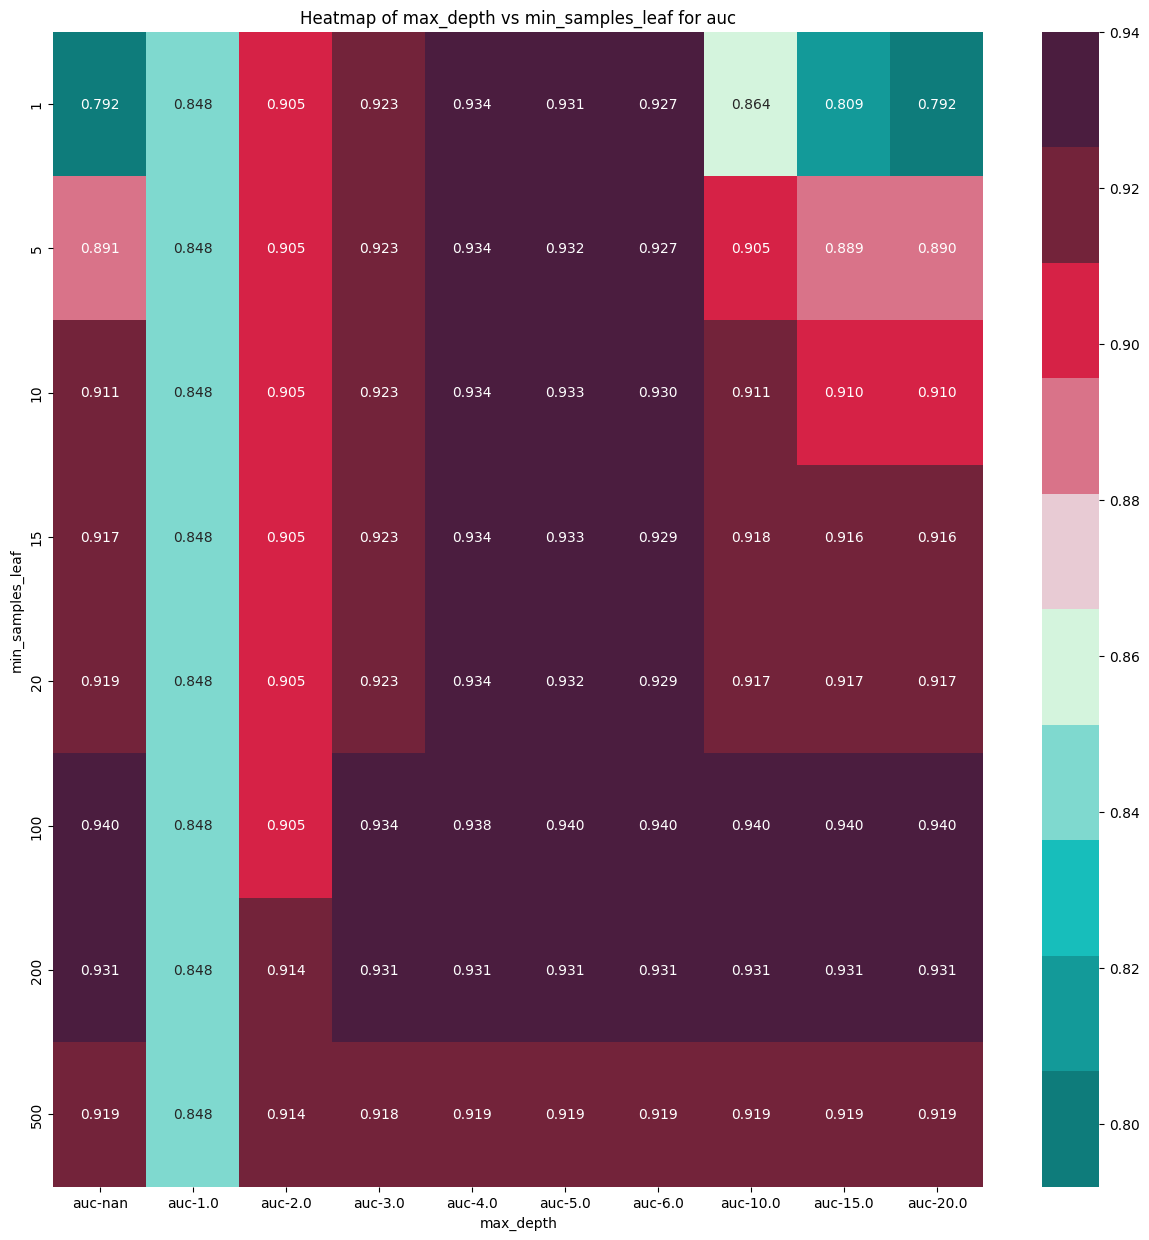

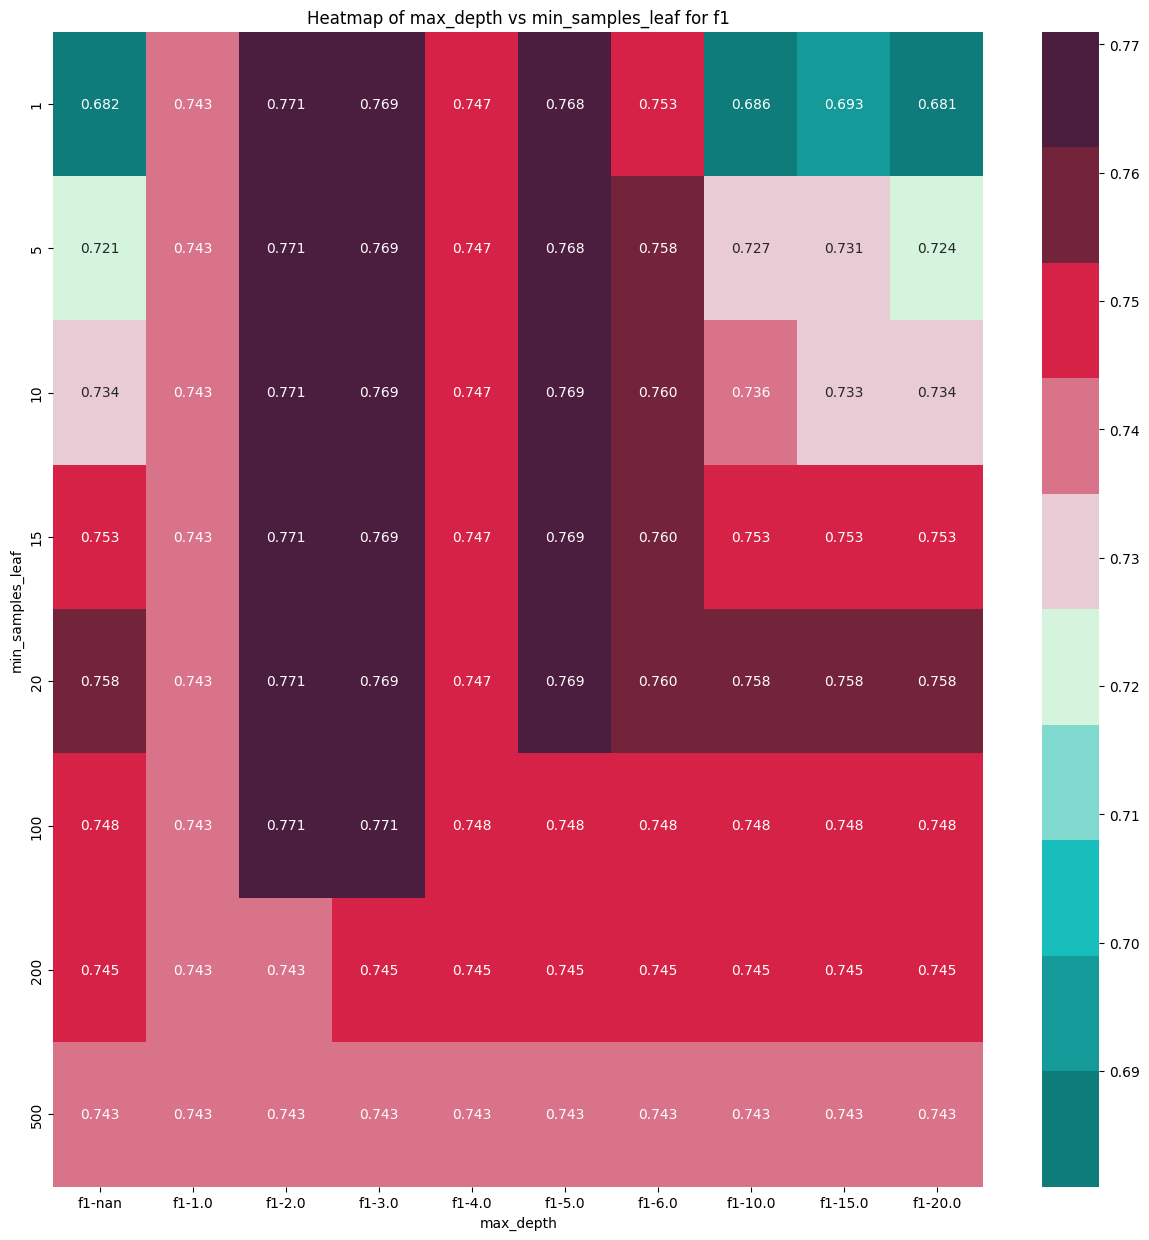

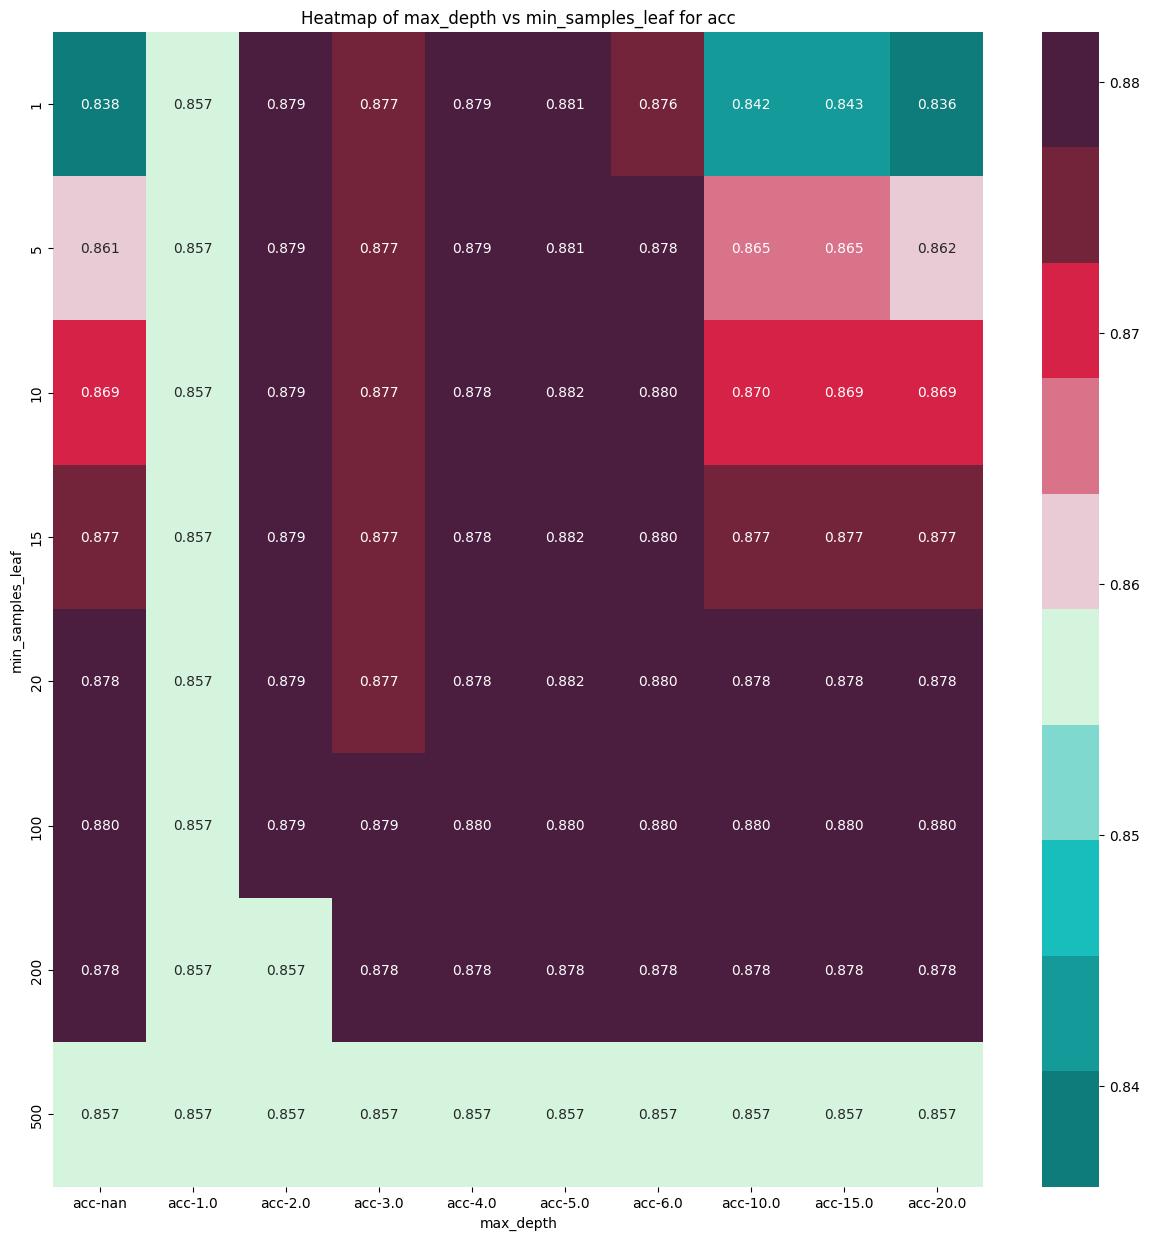

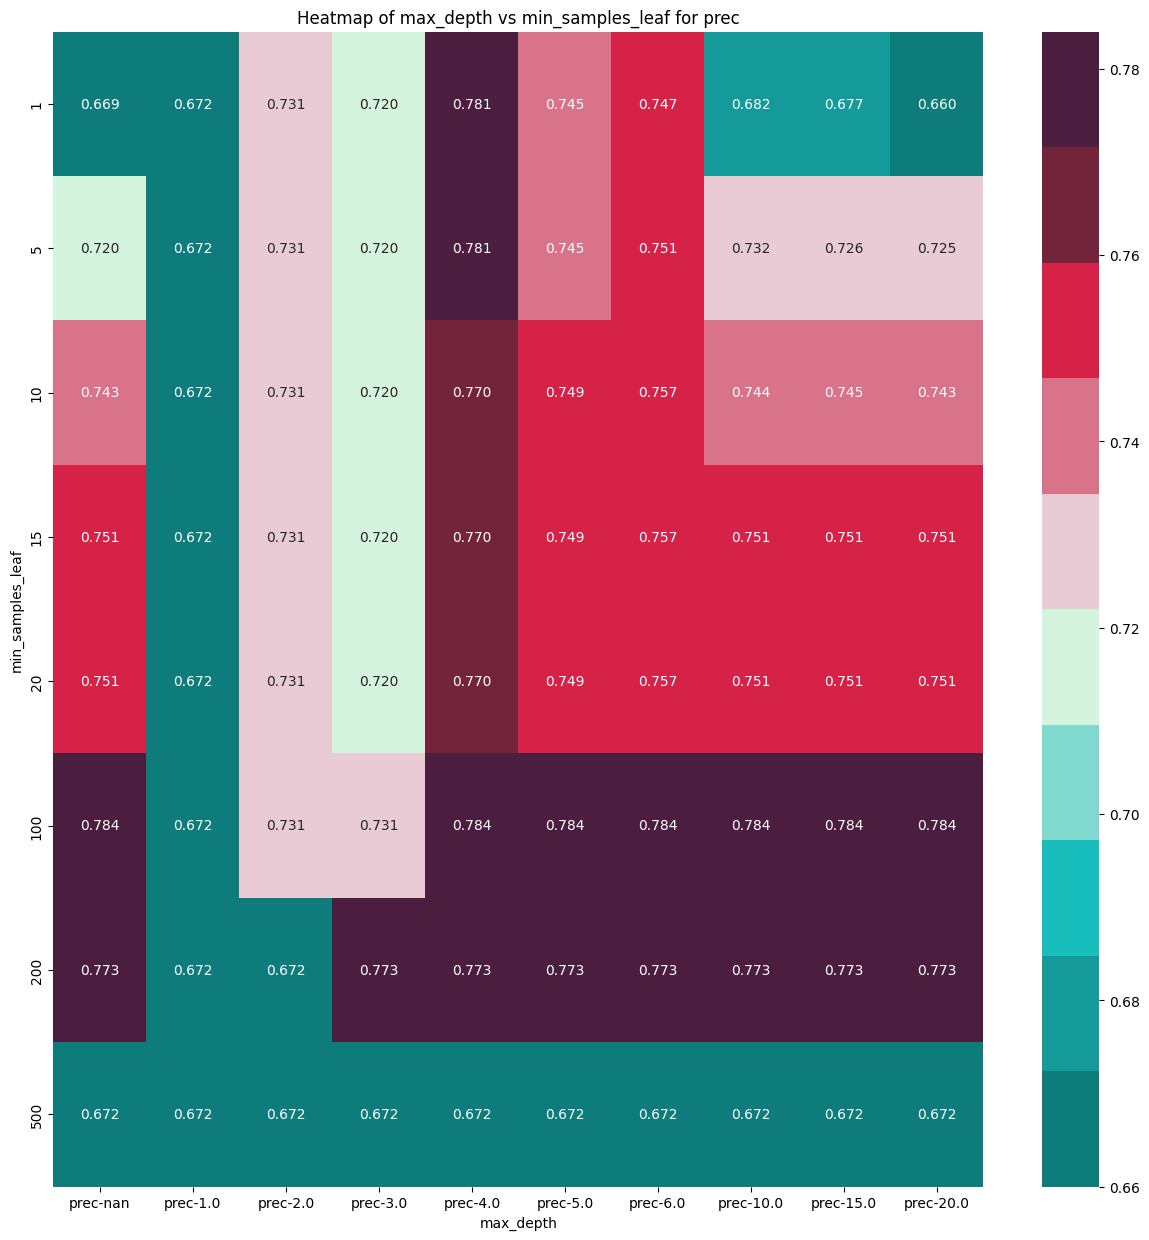

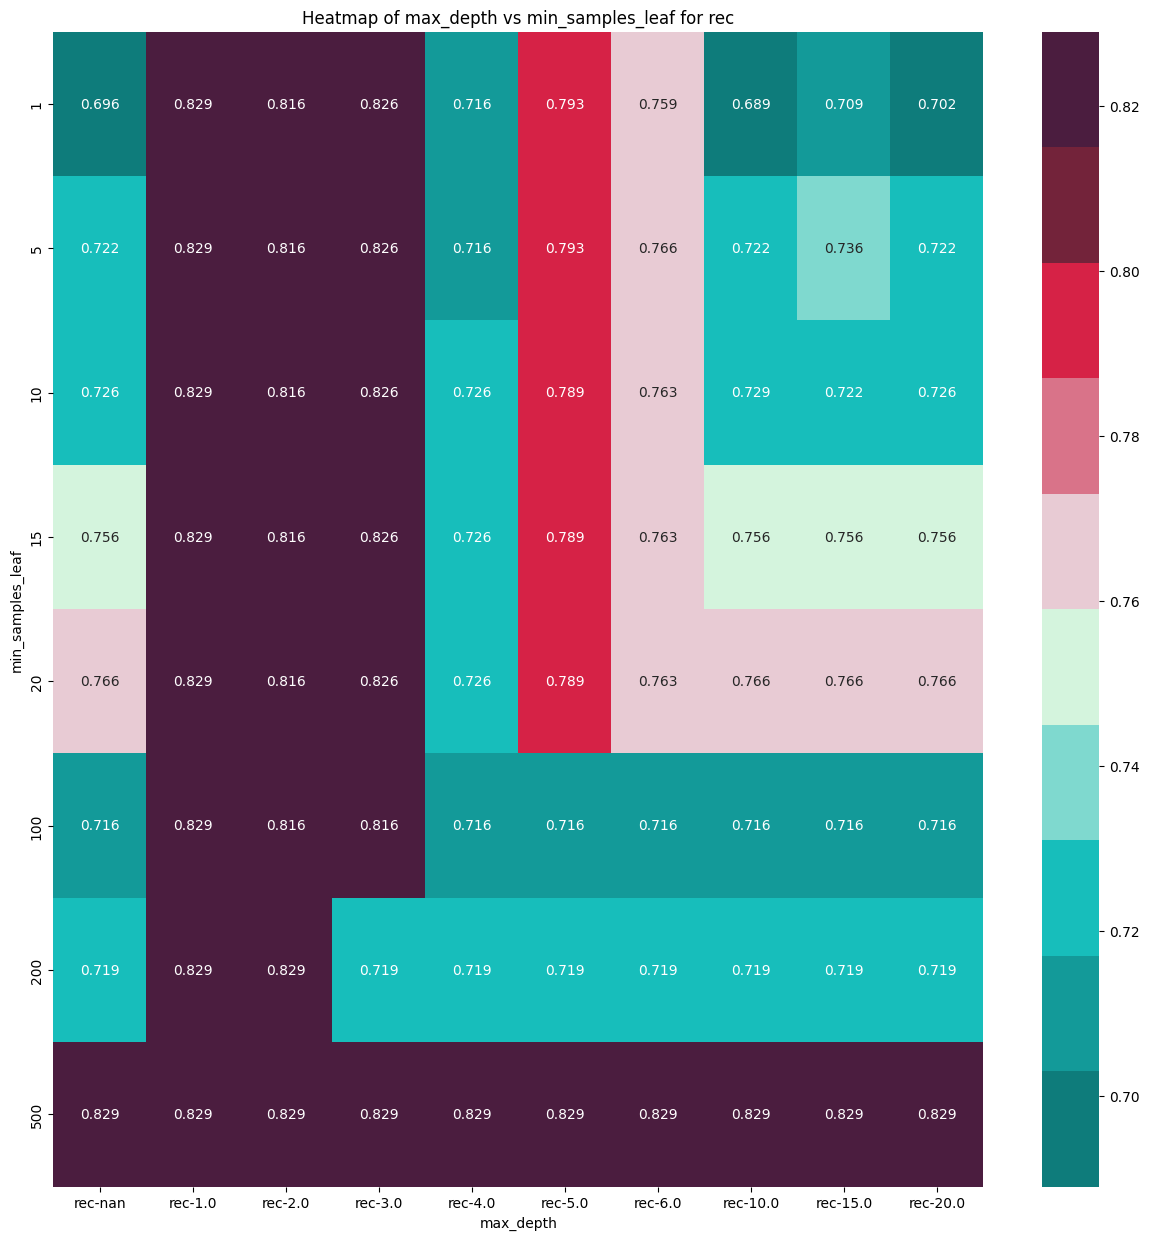

In [74]:
for metric in metrics:
    plot_dt_ft_eval(pivot_tables[f"dt_{metric}_pivot"], metric)

In [81]:
for metric in metrics:
    long_df = (
            pivot_tables[f"dt_{metric}_pivot"].stack()
            .reset_index()
            .rename(columns={0: metric})
        )

    top5 = long_df.sort_values(by=metric, ascending=False).head(5)
    top5.round(3)
    print(top5)

    min_samples_leaf  max_depth   auc
59               100       20.0  0.94
58               100       15.0  0.94
50               100        NaN  0.94
55               100        5.0  0.94
57               100       10.0  0.94
    min_samples_leaf  max_depth     f1
2                  1        2.0  0.771
12                 5        2.0  0.771
32                15        2.0  0.771
52               100        2.0  0.771
53               100        3.0  0.771
    min_samples_leaf  max_depth    acc
35                15        5.0  0.882
45                20        5.0  0.882
25                10        5.0  0.882
5                  1        5.0  0.881
15                 5        5.0  0.881
    min_samples_leaf  max_depth   prec
59               100       20.0  0.784
50               100        NaN  0.784
54               100        4.0  0.784
55               100        5.0  0.784
57               100       10.0  0.784
    min_samples_leaf  max_depth    rec
1                  1        1.0

/tmp/ipykernel_5087/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}_pivot"].stack()
/tmp/ipykernel_5087/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}_pivot"].stack()
/tmp/ipykernel_5087/2778617044.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pivot_tables[f"dt_{metric}_pi

100 min samples consistentley lead to good performance, across the most metrics, auc f1 and precision. 

5 was the most common max depth, that seems to not get too deep but get good performance. This may lead to better generalisation down the line.

### Random Forest Parameter Tuning

We will tune the following parameters:
- n_estimators
- max_depth
- min_samples_leaf

In [85]:
rf_ft_scores = []

for n in range(10, 301, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred >= 0.5)
    acc = accuracy_score(y_val, y_pred >= 0.5)
    prec = precision_score(y_val, y_pred >= 0.5)
    rec = recall_score(y_val, y_pred >= 0.5)

    rf_ft_scores.append((n, auc, f1, acc, prec, rec))
    

In [86]:
columns = ['n_estimators', 'auc', 'f1', 'acc', 'prec', 'rec']
df_rf_ft_scores = pd.DataFrame(rf_ft_scores, columns=columns)

In [88]:
df_rf_ft_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,auc,f1,acc,prec,rec
24,250,0.930701,0.747029,0.875833,0.758621,0.735786
25,260,0.930629,0.745763,0.875000,0.756014,0.735786
23,240,0.930560,0.751269,0.877500,0.760274,0.742475
21,220,0.930551,0.749153,0.876667,0.759450,0.739130
26,270,0.930531,0.744501,0.874167,0.753425,0.735786


In [89]:
df_rf_ft_scores.sort_values(by='f1', ascending=False).head()

,n_estimators,auc,f1,acc,prec,rec
11,120,0.927483,0.754209,0.878333,0.759322,0.749164
12,130,0.928933,0.754209,0.878333,0.759322,0.749164
5,60,0.926516,0.753769,0.877500,0.755034,0.752508
4,50,0.926603,0.752508,0.876667,0.752508,0.752508
13,140,0.928972,0.752108,0.877500,0.758503,0.745819
